In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import arviz as az
import pymc3 as pm
plt.style.use('ggplot')

precipitations = pd.read_excel('data/weather_merignac.xlsx', sheet_name='precipitations_mm', index_col=0)
temp_maximals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_maximals', index_col=0)
temp_minimals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_minimals', index_col=0)
frost_days = pd.read_excel('data/weather_merignac.xlsx', sheet_name='frost_days_count', index_col=0)
insulation = pd.read_excel('data/weather_merignac.xlsx', sheet_name='insulation', index_col=0)

ratings = pd.read_excel('data/ratings.xlsx')
#ratings = ratings[ratings['Category']=='Premier cru 1855']

#selected_vineyards = list(ratings['Chateau'].unique())
selected_vineyards = ['Château Lafite Rothschild Pauillac', 'Château Mouton Rothschild Pauillac', 'Château Latour Pauillac', 'Château Cheval Blanc', 'Château Ausone', 'Château Margaux', 'Château Haut-Brion Pessac-léognan', 'Château Angélus', 'Château Trotte Vieille', 'Château Palmer', 'Château Pavie', 'Petrus Pomerol', 'Château Léoville Las Cases Saint-Julien', 'Château Figeac', 'Château Pichon-Longueville Comtesse de Lalande Pauillac', 'Château Ducru-Beaucaillou Saint-Julien', 'Château Montrose Saint-Estèphe', 'Château Pichon-Longueville Baron Pauillac']
print(selected_vineyards)

ratings['Rating - Avg'] = (ratings['Rating - LB'] + ratings['Rating - HB'])/2
ratings = ratings.groupby('Vintage')['Rating - Avg'].mean().to_frame()


prices = pd.read_excel('data/prices.xlsx', index_col=0)
df = prices.drop('Category', axis=1).transpose().reset_index().melt(id_vars='index').rename(columns={'index':'Vintage', 'variable':'Chateau', 'value':'Price'})[['Chateau','Vintage','Price']]
df = df.replace(-100, np.NaN)
selected_prices = df[(df['Chateau'].isin(selected_vineyards))].fillna(method='ffill')
display(selected_prices['Chateau'].unique())
prices = selected_prices.groupby('Vintage')['Price'].mean().to_frame()

['Château Lafite Rothschild Pauillac', 'Château Mouton Rothschild Pauillac', 'Château Latour Pauillac', 'Château Cheval Blanc', 'Château Ausone', 'Château Margaux', 'Château Haut-Brion Pessac-léognan', 'Château Angélus', 'Château Trotte Vieille', 'Château Palmer', 'Château Pavie', 'Petrus Pomerol', 'Château Léoville Las Cases Saint-Julien', 'Château Figeac', 'Château Pichon-Longueville Comtesse de Lalande Pauillac', 'Château Ducru-Beaucaillou Saint-Julien', 'Château Montrose Saint-Estèphe', 'Château Pichon-Longueville Baron Pauillac']


array(['Château Lafite Rothschild Pauillac', 'Château Latour Pauillac',
       'Château Mouton Rothschild Pauillac', 'Château Margaux',
       'Château Haut-Brion Pessac-léognan',
       'Château Pichon-Longueville Baron Pauillac',
       'Château Pichon-Longueville Comtesse de Lalande Pauillac',
       'Château Montrose Saint-Estèphe',
       'Château Ducru-Beaucaillou Saint-Julien',
       'Château Léoville Las Cases Saint-Julien', 'Château Ausone',
       'Château Cheval Blanc', 'Château Pavie', 'Château Figeac',
       'Château Trotte Vieille', 'Château Angélus', 'Château Palmer',
       'Petrus Pomerol'], dtype=object)

# Feature engineering

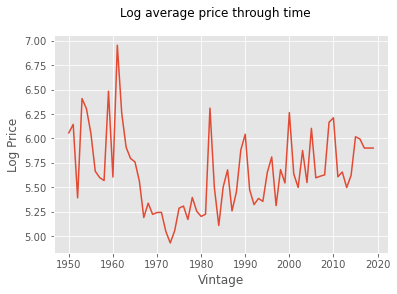

In [2]:
y = prices
y['Log Price'] = np.log(y['Price'])
sns.lineplot(data=y['Log Price'])
plt.suptitle('Log average price through time')
plt.show()

In [3]:
X = pd.DataFrame(index = precipitations.index).loc[1950:]

X['Winter Rain'] =  precipitations.shift(1)['Dec'] # really important


X['Harvest Rain'] =  precipitations['Mai']+precipitations['Jui']+precipitations['Juil']+precipitations['Aou']+ precipitations['Sep']*2


X['Winter Temperature'] = \
    (temp_maximals.shift(1)['Dec'] + temp_minimals.shift(1)['Dec'])+\
    (temp_maximals['Jan'] + temp_minimals['Jan'])+\
    (temp_maximals['Fev'] + temp_minimals['Fev'])

X['Square Winter Temperature'] = X['Winter Temperature']**2

X['Summer Temperature'] = \
    (temp_maximals['Mai'] + temp_minimals['Mai'])+\
    (temp_maximals['Jui'] + temp_minimals['Jui'])*2+\
    (temp_maximals['Juil'] + temp_minimals['Juil'])

X['Square Summer Temperature'] = X['Summer Temperature']**2


X['Harvest Temperature'] = \
                    (temp_maximals['Aou'] + temp_minimals['Aou'])+\
                    (temp_maximals['Sep'] + temp_minimals['Sep'])*3+\
                    (temp_maximals['Oct'] + temp_minimals['Oct'])*2


X['Square Harvest Temperature'] = X['Harvest Temperature']**2

#X['Past Year Quality'] = y['Log Price'].shift(1).fillna(0) - y['Log Price'].rolling(10).mean().shift(1).fillna(0)
#X['Frost Days'] = frost_days['Fev'] + 2*frost_days['Mar']+ 3*frost_days['Avr']+ 3*(frost_days['Mai'] + frost_days['Jui'])
display(X.head(30))
#X['Insulation'] = insulation.iloc[:,0] # negative on mean r2 and bad scores

,Winter Rain,Harvest Rain,Winter Temperature,Square Winter Temperature,Summer Temperature,Square Summer Temperature,Harvest Temperature,Square Harvest Temperature
Year,,,,,,,,
1950,86.2,292.5,39.6,1568.16,157.2,24711.84,190.7,36366.49
1951,137.9,510.6,34.9,1218.01,135.3,18306.09,192.0,36864.00
1952,96.3,399.4,32.7,1069.29,151.2,22861.44,183.6,33708.96
1953,244.4,320.3,26.2,686.44,135.4,18333.16,201.4,40561.96
1954,11.5,326.7,38.0,1444.00,127.9,16358.41,197.6,39045.76
1955,79.2,478.8,45.4,2061.16,141.2,19937.44,190.9,36442.81
1956,124.9,456.4,24.4,595.36,128.8,16589.44,191.0,36481.00
1957,56.0,385.2,41.4,1713.96,137.1,18796.41,189.3,35834.49
1958,91.9,557.8,39.8,1584.04,136.4,18604.96,206.0,42436.00


# Building an exploratory model

In [4]:
from sklearn.preprocessing import StandardScaler

X = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns).loc[1950:,:]


column_names = X.columns.to_list()
print(column_names)

['Winter Rain', 'Harvest Rain', 'Winter Temperature', 'Square Winter Temperature', 'Summer Temperature', 'Square Summer Temperature', 'Harvest Temperature', 'Square Harvest Temperature']


In [34]:
pm.traceplot(trace['nu'])
pm.traceplot(trace['sigma intercept'])
pm.traceplot(trace['sigma coeffs'])

KeyError: 'Unknown variable nu'

Runtime of below, 
- when having to estimate sigma coeffs, sigma intercept and nu: 8min35, 7min17, 7min13
- when sigma coeffs, sigma intercept and nu are fixed: 5min55, 5min33, 5min50, less errors

In [9]:
CONSTANT_COEFFS = ['Harvest Temperature', 'Square Harvest Temperature',\
                   'Summer Temperature', 'Square Summer Temperature',\
                   'Winter Temperature', 'Square Winter Temperature']

## Findings:

- Harvest Temperature et Square Harvest Temperature: les GaussianRandomWalk sont constantes (a 1.6 et -1.6), donc on peut les remplacer par des constantes
- Winter Temperature et Square Winter Temperature: les GaussianRandomWalk sont constantes (a -0.4 et 0.4), donc on peut les remplacer par des constantes
- Le temps de recherche semple a peu pres proportionnel au nombre de GaussianRandomWalk
- GaussianRandomWalk for Frost Days shows their impact has nearly vanished in recent years. Therefore it adds small benefits to the study
- Past year quality seems to introduce bad inertia in the predictions

In [14]:
import pymc3 as pm # Last correct version: 3.7.0

with pm.Model() as model:
    #sigma_coeffs = pm.Exponential('sigma coeffs', 1/.01, testval=1) # Random walk jump size
    #sigma_intercept = pm.Exponential('sigma intercept', 1/.01, testval=1) # Random walk jump size
    sigma_coeffs = 0.013
    sigma_intercept = 0.055
    #nu = pm.Exponential('nu', 1./0.2) # Observation noise
    nu = 0.255
    column_names_short = [i for i in column_names if i not in CONSTANT_COEFFS]
    
    coeffs = [(pm.GaussianRandomWalk(coeff_name, mu=0, sigma=sigma_coeffs, shape=len(y)), coeff_name) \
                for coeff_name in column_names_short]
    coeffs.append((pm.Normal('Harvest Temperature', mu=1.6, sd=0.3), 'Harvest Temperature'))
    coeffs.append((pm.Normal('Square Harvest Temperature', mu=-1.5, sd=0.3), 'Square Harvest Temperature'))
    coeffs.append((pm.Normal('Winter Temperature', mu=-0.4, sd=0.3), 'Winter Temperature'))
    coeffs.append((pm.Normal('Square Winter Temperature', mu=0.4, sd=0.3), 'Square Winter Temperature'))
    coeffs.append((pm.Normal('Summer Temperature', mu=0.5, sd=0.3), 'Summer Temperature'))
    coeffs.append((pm.Normal('Square Summer Temperature', mu=-0.5, sd=0.3), 'Square Summer Temperature'))
    #coeffs.append((pm.Normal('Past Year Quality', mu=0.07, sd=0.2), 'Past Year Quality'))

    intercept = pm.GaussianRandomWalk('intercept', mu=0, sigma=sigma_intercept, shape=len(y))
    
    mu = 6 + intercept 
    for (coeff, coeff_name) in coeffs:
        mu += coeff * X[coeff_name]
        
    observed = pm.Normal('observed', mu, sd=nu, observed=y['Log Price'])
    trace_global = pm.sample(2000,chains=2, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, Square Summer Temperature, Summer Temperature, Square Winter Temperature, Winter Temperature, Square Harvest Temperature, Harvest Temperature, Harvest Rain, Winter Rain]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 5000/5000 [02:16<00:00, 36.63draws/s]


In [17]:
model.free_RVs

[Winter Rain,
 Harvest Rain,
 Harvest Temperature,
 Square Harvest Temperature,
 Winter Temperature,
 Square Winter Temperature,
 Summer Temperature,
 Square Summer Temperature,
 intercept]

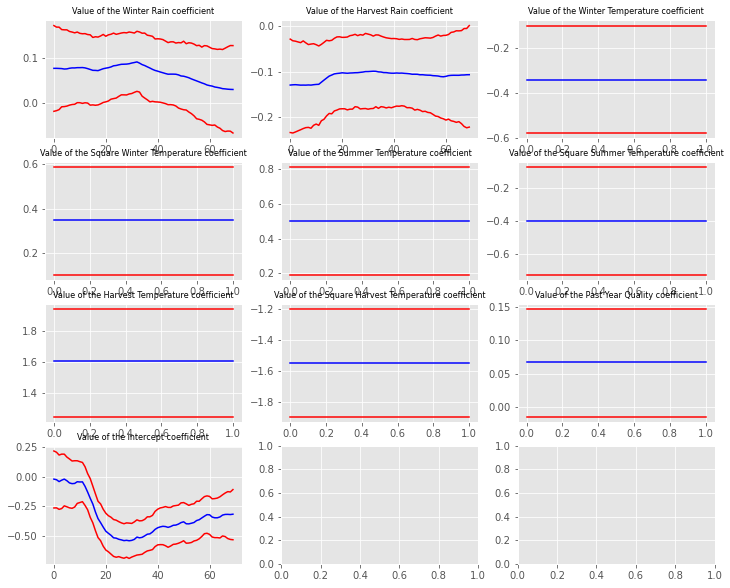

In [91]:
all_names = column_names+['intercept']

f, axs = plt.subplots(len(all_names)//3+1, 3)
f.set_size_inches(12,10)
for i in range(len(all_names)):
    coeff_name = all_names[i]
    subplot = axs[i//3, i%3]

    if coeff_name in CONSTANT_COEFFS:
        subplot.plot([mean[coeff_name]]*2, color='blue')
        subplot.plot([high_95[coeff_name]]*2, color='r')
        subplot.plot([low_95[coeff_name]]*2, color='r')
    else:
        subplot.plot(mean[coeff_name], color='blue')
        subplot.plot(high_95[coeff_name], color='r')
        subplot.plot(low_95[coeff_name], color='r')
    subplot.set_title('Value of the '+coeff_name+' coefficient', fontsize=8)
plt.show()

So far, this looks really good. Notice how the harvest temperature decreases to 0: a quadratic effect could be reached.

## Plotting results

In [102]:
X_vintage = X
vintage_index = X_vintage.index.values

mean_HMC_global = extract_mean_from_trace(trace_global, 1000)
predictions=[]
for vintage in range(len(X)):
    prediction = 6 + mean_dict_global['intercept'][vintage]
    for coeff in column_names:
        if coeff in CONSTANT_COEFFS:
            prediction += mean_dict_global[coeff] * X_vintage[coeff][vintage+1950]
        else:
            prediction += mean_dict_global[coeff][vintage] * X_vintage[coeff][vintage+1950]
    predictions.append(prediction)

print(predictions)


[6.002325400495755, 5.868825303875903, 5.964814333288423, 6.326026210748845, 5.862033174421335, 5.897414020359927, 5.883003699260989, 5.817110136058606, 5.849134411379002, 6.1141730769948355, 5.689227935521703, 6.127395918632621, 5.996472283895661, 5.822020806286801, 5.878326911002637, 5.3387704733927865, 5.842103377894075, 5.684042845148435, 5.238373306421227, 5.231330523193055, 5.605350521482212, 5.286108324931947, 4.897123808553702, 5.319954698528546, 4.950331775261889, 5.382835260222457, 5.331517256260125, 5.275137440923519, 5.33659870277442, 5.415713809021819, 5.285582875432776, 5.4032951770130335, 5.804522019236952, 5.711027229004246, 5.242299616575179, 5.5152224246318715, 5.556450412614737, 5.4926848214710455, 5.551110976659501, 5.75566331198749, 5.870862904837279, 5.376047690158639, 5.231266200680458, 5.242152929772481, 5.658929460477503, 5.7065451101151545, 5.621214045234737, 5.501249541811004, 5.723501114646415, 5.469128469252349, 5.832818285531939, 5.914464883023453, 5.62425

From -30 to -5
### With all 5 base features + square harvest temperature:

Spearman correlation between results and real log prices: 
 0.7684615384615385
 
R2 between results and real log prices: 
 -0.052318688276817404
 
### With all 5 base features + square harvest, summer and winter:



###### Winter temp coeff initialized to: temperature negative, square winter temp positive

Spearman correlation between results and real log prices: 
 0.7430769230769232
 
R2 between results and real log prices: 
 -0.12716061931460976

###### Only summer and summer square random walks, summer taking -0.5 coeff and square 0.5 (weird), with frost days
Spearman correlation between results and real log prices: 
 0.7846153846153846

R2 between results and real log prices: 
 0.020928624681028296

MAE between results and real log prices: 
 0.16046999698162723
 
##### All temperatures constant, summer and summer square corrected different than gaussian, with frost days
Spearman correlation between results and real log prices: 
 0.7576923076923077

R2 between results and real log prices: 
 -0.11866645665076758

MAE between results and real log prices: 
 0.16319599034664248
 
 
##### All temperatures constant, summer and summer square corrected different than gaussian, without frost days

Spearman correlation between results and real log prices: 
 0.7669230769230769

R2 between results and real log prices: 
 -0.05875304209724219

MAE between results and real log prices: 
 0.16520215994075993



 
 
# last:

Spearman correlation between results and real log prices: 
 0.7638461538461538

R2 between results and real log prices: 
 -0.03504733390556325

MAE between results and real log prices: 
 0.16676518887458794


## With last year
Spearman correlation between results and real log prices: 
 0.7638461538461538

R2 between results and real log prices: 
 0.007120330611151915

MAE between results and real log prices: 
 0.1652437894521807


## Without

Spearman correlation between results and real log prices: 
 0.7623076923076924

R2 between results and real log prices: 
 -0.06744059329139218

MAE between results and real log prices: 
 0.16599584729482167


# With frost days

Spearman correlation between results and real log prices: 
 0.7500000000000001

R2 between results and real log prices: 
 -0.035866925565070096

MAE between results and real log prices: 
 0.1633591301731515
 
# All temperatures squared, without frost days, constant past year coeff
Spearman correlation between results and real log prices: 
 0.7607692307692308

R2 between results and real log prices: 
 -0.035086062969645004

MAE between results and real log prices: 
 0.16631474557967058

Spearman correlation between results and real log prices: 
 0.7553846153846154

R2 between results and real log prices: 
 -0.04143513750540717

MAE between results and real log prices: 
 0.16546413957274045


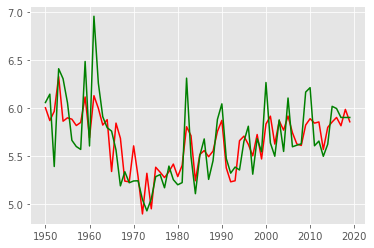

In [93]:
from scipy.stats import spearmanr
from sklearn.metrics import r2_score

plt.plot(vintage_index, predictions, color='r')
plt.plot(y['Log Price'], color='g')
print('Spearman correlation between results and real log prices: \n', spearmanr(predictions[-30:-5], y['Log Price'].values[-30:-5]).correlation)
print('\nR2 between results and real log prices: \n', r2_score(predictions[-30:-5], y['Log Price'].values[-30:-5]))
print('\nMAE between results and real log prices: \n', np.mean(np.abs(predictions[-30:-5] - y['Log Price'].values[-30:-5])))

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

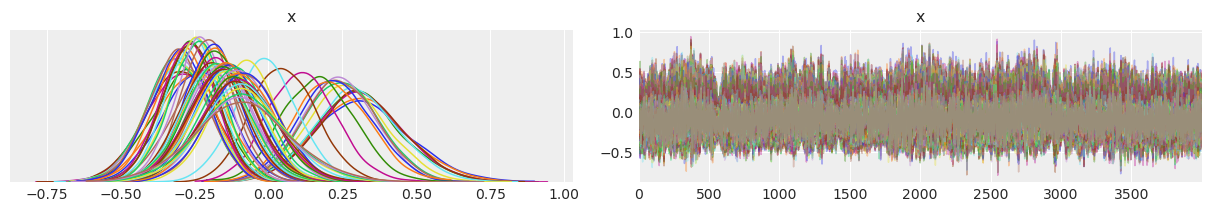

In [116]:
import warnings
warnings.filterwarnings("ignore")
pm.traceplot(trace['intercept'])

In [53]:
az.summary(trace)['r_hat']

winter rain coeff[0]    1.01
winter rain coeff[1]    1.01
winter rain coeff[2]    1.01
winter rain coeff[3]    1.01
winter rain coeff[4]    1.01
                        ... 
intercept[68]           1.02
intercept[69]           1.01
sigma coeffs            1.47
sigma intercept         1.14
nu                      1.01
Name: r_hat, Length: 423, dtype: float64

<AxesSubplot:>

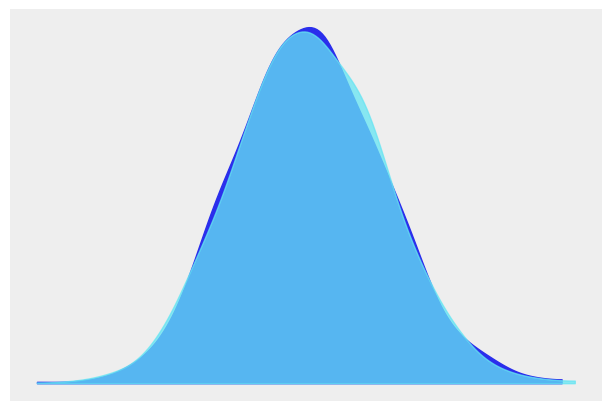

In [519]:
pm.energyplot(trace, legend=False, figsize=(6, 4))

# All mobile coeffs predictive model

The procedure will go as follows to predict the quality of one year: the HMC model will be run for up to the predicted model, the mean will then be interpolated by a polynomial, and the prolongation of the said polynomial will finally give the value of the coefficients for the next year, thus leading to a prediction.

NameError: name 'trace' is not defined

In [18]:
def extrapolate_next_coefficients(vintage_index, mean_dict):
    next_coeff_values={}
    for coeff in mean_dict.keys():
        z = np.polyfit(vintage_index[-10:], mean_dict[coeff][-10:], 2)
        p = np.poly1d(z)
        plt.plot(vintage_index, mean_dict[coeff], color='green')
        plt.plot(vintage_index[-10:], p(vintage_index)[-10:], color='orange')
        plt.show()
        next_coeff_values[coeff] = p(vintage_index[-1]+1)
    return next_coeff_values

def extract_mean_from_trace(trace, getback, model):
    coeffs = model.free_RVs
    mean_dict = {}
    for coeff in coeffs:
        if coeff in CONSTANT_COEFFS:
            mean_dict[coeff] = np.mean(trace[coeff][-getback:])
        else:
            mean_dict[coeff] = np.mean(trace[coeff][-getback:, :])
    return mean_dict

        

In [20]:
def get_HMC_mean_curves(X, y, vintage, fixed_coeffs=None):
    print('Building curves for vintage ', vintage)
    X_vintage = X.loc[:vintage-1, :]
    y_vintage = y.loc[:vintage-1, :]
    
    with pm.Model() as model:
        #sigma_coeffs = pm.Exponential('sigma coeffs', 1/.01, testval=1) # Random walk jump size
        #sigma_intercept = pm.Exponential('sigma intercept', 1/.01, testval=1) # Random walk jump size
        sigma_coeffs = 0.013
        sigma_intercept = 0.055
        #nu = pm.Exponential('nu', 1./0.2) # Observation noise
        nu = 0.255
        column_names_short = [i for i in column_names if i not in CONSTANT_COEFFS]
        
        coeffs = [(pm.GaussianRandomWalk(coeff_name, mu=0, sigma=sigma_coeffs, shape=len(y_vintage)), coeff_name) \
                    for coeff_name in column_names_short]
        if fixed_coeffs==None:
            coeffs.append((pm.Normal('Harvest Temperature', mu=1.6, sd=0.3), 'Harvest Temperature'))
            coeffs.append((pm.Normal('Square Harvest Temperature', mu=-1.5, sd=0.3), 'Square Harvest Temperature'))
            coeffs.append((pm.Normal('Winter Temperature', mu=-0.4, sd=0.3), 'Winter Temperature'))
            coeffs.append((pm.Normal('Square Winter Temperature', mu=0.4, sd=0.3), 'Square Winter Temperature'))
            coeffs.append((pm.Normal('Summer Temperature', mu=0.5, sd=0.3), 'Summer Temperature'))
            coeffs.append((pm.Normal('Square Summer Temperature', mu=-0.5, sd=0.3), 'Square Summer Temperature'))
                
            
        intercept = pm.GaussianRandomWalk('intercept', mu=0, sigma=sigma_intercept, shape=len(y_vintage))
        
        mu = 6 + intercept 
        for (coeff, coeff_name) in coeffs:
            mu += coeff * X_vintage[coeff_name]
            
        if fixed_coeffs !=None:
            for coeff in list(fixed_coeffs.keys()):
                mu += fixed_coeffs[coeff] * X_vintage[coeff]
            
        observed = pm.Normal('observed', mu, sd=nu, observed=y_vintage['Log Price'])
        trace = pm.sample(2500,chains=2, target_accept=0.9)
        
    mean_dict = extract_mean_from_trace(trace, 1000, model)
    return mean_dict

In [21]:
mean_HMC = {}
for vintage in range(1994, 2016):
    mean_HMC[vintage]= get_HMC_mean_curves(X,y, vintage)  

Building curves for vintage  1994


AttributeError: 'NoneType' object has no attribute 'keys'

In [162]:
def predict_from_HMC_curves(mean_HMCs, HMC_stop_date, vintage, plot=False):
    #print('Predicting for vintage: ', vintage)
    mean_HMC = mean_HMCs[HMC_stop_date]
    vintage_index = range(1950, HMC_stop_date)
    
    
    if plot:
        f, axs = plt.subplots((len(mean_HMCs.keys())-len(CONSTANT_COEFFS))//3, 3)

    next_coeff_values={}
    coeff_names = list(mean_HMC.keys())
    
    for i in range(len(coeff_names)):
        coeff = coeff_names[i]
        if coeff in CONSTANT_COEFFS:
            next_coeff_values[coeff] = mean_HMC[coeff]
        else:
            z = np.polyfit(vintage_index[-20:], mean_HMC[coeff][-20:], 2)
            p = np.poly1d(z)
            next_coeff_values[coeff] = np.mean(mean_HMC[coeff][-10:])# p(vintage) #    
        
            if plot:
                subplot = axs[i//3, i%3]
                subplot.plot(vintage_index, mean_HMC[coeff], color='green')
                subplot.plot(vintage_index[-20:], p(vintage_index)[-20:], color='orange')
                subplot.set_title(coeff)

    plt.show()
        

    return next_coeff_values

In [173]:
predictions=[]
coeff_record = {}
for coeff_name in column_names+['intercept']:
    coeff_record[coeff_name] = []
    
for vintage in range(1994, 2016):
    next_coeff_values = predict_from_HMC_curves(mean_HMC, 1994+ (vintage-1994)//10*10, vintage, plot=False)
    prediction = 6 + next_coeff_values['intercept'] 
    for coeff in column_names:
        prediction += next_coeff_values[coeff] * X.loc[vintage, coeff]
        
    for coeff in column_names+['intercept']:
        coeff_record[coeff].append(next_coeff_values[coeff])

    predictions.append(prediction) 
    
print(coeff_record['intercept'])

[-0.45959568125450767, -0.45959568125450767, -0.45959568125450767, -0.45959568125450767, -0.45959568125450767, -0.45959568125450767, -0.45959568125450767, -0.45959568125450767, -0.45959568125450767, -0.45959568125450767, -0.45846194071987084, -0.45846194071987084, -0.45846194071987084, -0.45846194071987084, -0.45846194071987084, -0.45846194071987084, -0.45846194071987084, -0.45846194071987084, -0.45846194071987084, -0.45846194071987084, -0.3750222214874647, -0.3750222214874647]


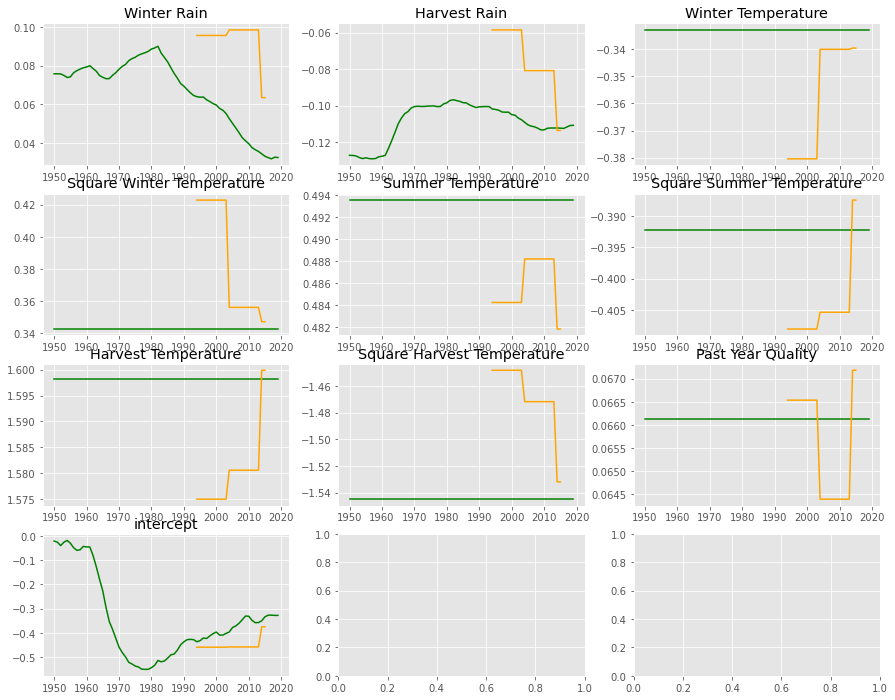

In [174]:
plt.rcParams['figure.figsize']= [15, 12]
f, axs = plt.subplots(4, 3)
coeff_list = list(mean_HMC_global.keys())
for i in range(len(coeff_list)):
    coeff = coeff_list[i]
    subplot = axs[i//3, i%3]
    if coeff in CONSTANT_COEFFS:
        subplot.plot(range(1950, 2020), [mean_HMC_global[coeff]]*70, color='green')
    else:
        subplot.plot(range(1950, 2020), mean_HMC_global[coeff], color='green')
        
    subplot.plot(range(1994, 2016), coeff_record[coeff], color='orange')
    subplot.set_title(coeff) 


Spearman correlation: 
SpearmanrResult(correlation=0.39582156973461324, pvalue=0.06822788864462451)

R2 score: 
0.025302295991555313


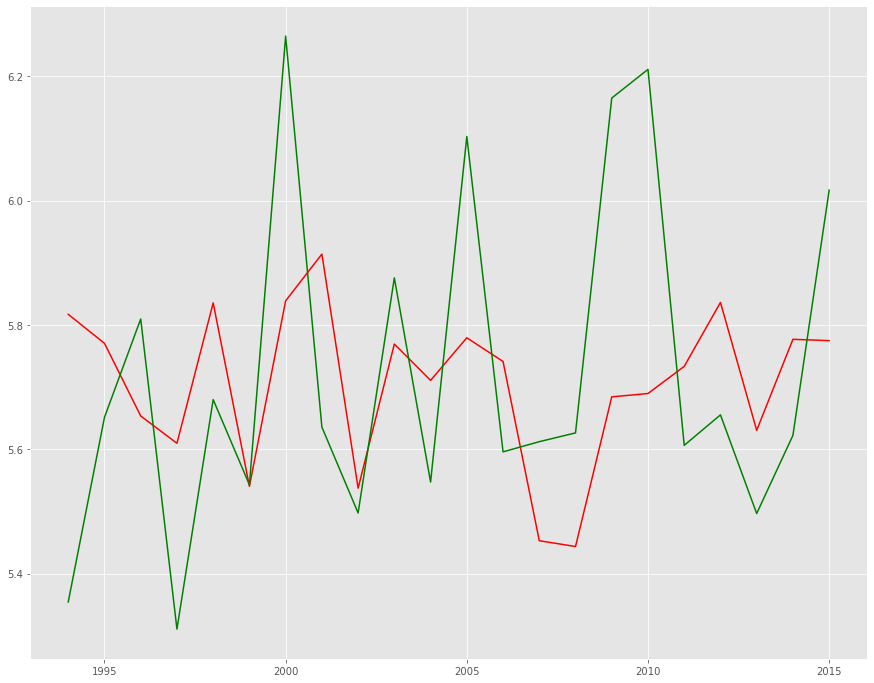

In [175]:
  
plt.plot(y.loc[1994:2015, 'Log Price'].index, predictions, color='r')
plt.plot(y.loc[1994:2015, 'Log Price'], color='g')

print('\nSpearman correlation: ')
print(spearmanr(y.loc[1994:2015, 'Log Price'], predictions))


print('\nR2 score: ')
print(r2_score(y.loc[1994:2015, 'Log Price'], predictions))

### Avec fenetre maximale, bcp de parametres, prediction dde 1994 a 2015 selon des parametres de tous les 10 ans:

Spearman correlation: 
SpearmanrResult(correlation=0.39582156973461324, pvalue=0.06822788864462451)

R2 score: 
0.025302295991555313

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

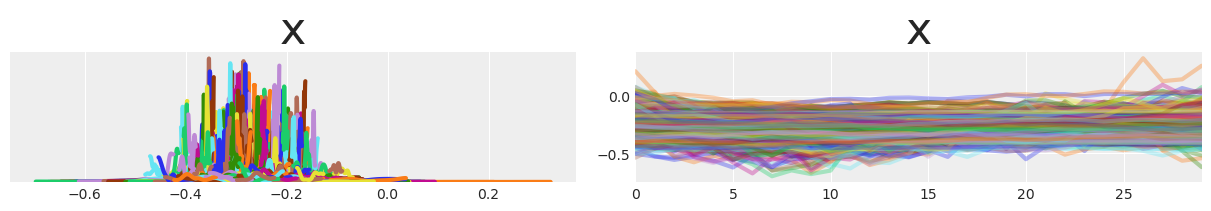